**Provide a path to the url.mat file**

In [2]:
import scipy.io
data = scipy.io.loadmat('../../url.mat')
#'../../data/url.mat'

**Create a list for labels and data, where one entry is the data for the day with the corresponding index**

In [3]:
import numpy as np

num_of_days = 120
X, Y = [], []

for i in range(num_of_days):
    day_data = data["Day" + str(i)]
    X.append(day_data[0][0][0])
    Y.append(day_data[0][0][1])

# Data cleanup (remove list within list)
for i in range(len(Y)):
    Y[i] = Y[i].ravel()

**Function to do continous learning on a given classifier (clf) which must provide the partial_fit() function**

*A batch size can be set, in order to train on a batch of URLs instead of individual URLs (to achieve classic online-learning, just set batch_size to 1*

*Returns an array of cumulative error rates for each day*

In [4]:
def learn_incremental(clf, batch_size = 1000):
    
    error_rates = []
    num_of_days = 120
    err = 0
    
    for curr_day in range(num_of_days): # Looping through days
    
        if (curr_day != 45): # Day 45 has faulty data and is therefor excluded
            
            X_curr_day = X[curr_day]
            batches_amount = int(X_curr_day.shape[0] / batch_size)
            Y_curr_day = np.array_split(Y[curr_day], batches_amount)
    
            for j in range(batches_amount): # looping through individual url-batches
            
                # Split the data in slices of the batch_size
                select_ind = np.arange(j * batch_size, (j+1) * batch_size)
                X_curr_url_batch, Y_curr_url_batch = X_curr_day[select_ind,:], Y_curr_day[j] 
        
                if (j > 0):
                    Y_preds = clf.predict(X_curr_url_batch)
            
                    for k in range(batch_size): # Compare given results to collected results and collect number of errors accordingly
                        if(Y_preds[k] != Y_curr_url_batch[k]):
                            err = err + 1
        
                # Continous fitting of urls and label
                clf.partial_fit(X_curr_url_batch, Y_curr_url_batch, classes=list(range(2)))            
            print("Log: Day {}: {}".format(curr_day ,err / X_curr_day.shape[0]))
            error_rates.append(err / X_curr_day.shape[0])
            err = 0
    return error_rates

In [47]:
from scipy.sparse import vstack
from scipy.sparse import csr_matrix

# takes a range of days (start until to)
# fits the model with the data from the range until "to" itself
# for day "to" for each url_batch the data is refitted (prevoius days data from range + all batches up to current)
# and predicticed for the succesive batch of urls
# returns the cumulative error rate for day "to"
# batch_size determines the size of url_batches for which data is predicted and fitted on the "to" day
def train_and_evaluate(start, to, clf, batch_size = 1):
    
    if (to == 45):
        print("ERROR CALLED ON 45 WHICH CONTAINS FAULTY DATA")
        return
    
    prev_x = X[0][0,:] #random row for initialization purposes, spliced off later before classifying
    
    prev_y = []
    for prev_day in range(start, to):
        
        if (prev_day != 45): # leave out day 45
            prev_x = vstack((prev_x, X[prev_day])) # stack up all matrices to previous day
            prev_y = np.concatenate((prev_y, Y[prev_day])) # stack up all labels to previous day
        
    # immediately splice off the first initial url used to initiate the matrix outside of the loop
    url_indexes_without_initial = np.arange(1, prev_x.shape[0])
    prev_x = prev_x.tocsr()[url_indexes_without_initial,:]
    
    # change X to row format for faster slicing row-wise.
    curr_day_x = X[to].tocsr()
    
    # split the data in slices of batch_size
    batches_amount = int(curr_day_x.shape[0] / batch_size)
    curr_day_y = np.array_split(Y[to], batches_amount)
    
    err = 0
    x_batches = X[0][0,:] #random row for initialization purposes, spliced off later before classifying
    y_batches = []
    for j in range(batches_amount): # looping through individual url-batches
       
        # Combine previous days data and all batches up until current
        #print("parts:")
        #print("current batches: {}".format(x_batches.shape))
        #print("previous: {}".format(prev_x.shape))
        x_combined = vstack((prev_x, x_batches))
        #y_combined = prev_y.extend(y_batches.ravel())
        y_combined = np.append(prev_y, y_batches)
        #print("unsliced comb:  {}".format(x_combined.shape))
        
        if (j == 0):
            # immediately splice off the trailing url used to initiate the matrix outside of the loop
            url_indexes_without_trailing = np.arange(0, prev_x.shape[0])
            x_combined = x_combined.tocsr()[url_indexes_without_trailing,:]
            
            
        #print("sliced comb:  {}".format(x_combined.shape))
        #print("y-sliced comb:  {}".format(len(y_combined)))
        
        
        # Train for cumulated data excluding current batch
        if (x_combined.shape[0] != 0):
            clf.fit(x_combined, y_combined)
    
        # splice current batch off
        select_ind = np.arange(j * batch_size, (j+1) * batch_size)
        curr_x_batch, curr_y_batch = curr_day_x[select_ind,:], curr_day_y[j] 
        
        # Add current batch to cumulated list of batches
        x_batches = vstack((x_batches, curr_x_batch))
        if (j == 0):
            # immediately splice off the first initial url used to initiate the matrix outside of the loop
            url_indexes_without_initial = np.arange(1, x_batches.shape[0])
            x_batches = x_batches.tocsr()[url_indexes_without_initial,:]
            
        y_batches.extend(curr_y_batch)
        
        # Predict for current batch
        if (x_combined.shape[0] != 0):
            Y_preds = clf.predict(curr_x_batch)
           
            # Collect errors
            # todo replace with accuracy score
            for k in range(batch_size):
                if(Y_preds[k] != curr_y_batch[k]):
                    err = err + 1
        
    return err / curr_day_x.shape[0] # Return cumulative error rate

### Batch-size and other global variables and imports:

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
import numpy as np

batch_size = 4000
train_set_size = 17 # Determines on data of how many days training is performed for SVM-multi and SVM-multi-once

# Initialize error rates of the different classifiers
error_rates_pa = None
error_rates_svm_once = None
error_rates_svm_daily = None
error_rates_svm_multi_once = None
error_rates_svm_multi = None

### SVM-once
**Evaluate for all days**

In [49]:
clf = LinearSVC(C=0.01)

error_rates_svm_once = []
rate = train_and_evaluate(0, 0, clf, batch_size)
print("Error-rate Day {}   : {}".format(0, rate))
error_rates_svm_once.append(rate)

for i in range(1, num_of_days):
    Y_preds = clf.predict(X[i])
    rate = 1 - accuracy_score(Y[i], Y_preds)
    error_rates_svm_once.append(rate)
    print("Error-rate Day {}   : {}".format(i,rate))


Error-rate Day 0   : 0.0211875
Error-rate Day 1   : 0.027800000000000047
Error-rate Day 2   : 0.023349999999999982
Error-rate Day 3   : 0.023050000000000015
Error-rate Day 4   : 0.025900000000000034
Error-rate Day 5   : 0.02849999999999997
Error-rate Day 6   : 0.03254999999999997
Error-rate Day 7   : 0.03590000000000004
Error-rate Day 8   : 0.036699999999999955
Error-rate Day 9   : 0.039100000000000024
Error-rate Day 10   : 0.036800000000000055
Error-rate Day 11   : 0.03500000000000003
Error-rate Day 12   : 0.029299999999999993
Error-rate Day 13   : 0.023700000000000054
Error-rate Day 14   : 0.032299999999999995
Error-rate Day 15   : 0.027349999999999985
Error-rate Day 16   : 0.029299999999999993
Error-rate Day 17   : 0.02595000000000003
Error-rate Day 18   : 0.02595000000000003
Error-rate Day 19   : 0.026249999999999996
Error-rate Day 20   : 0.03480000000000005
Error-rate Day 21   : 0.041649999999999965
Error-rate Day 22   : 0.04085000000000005
Error-rate Day 23   : 0.0383999999999999

### SVM-daily
**Train on data of previous day and predict of successive day**

In [8]:
clf = LinearSVC(C=0.01)

error_rates_svm_daily = []
error_rates_svm_daily.append(train_and_evaluate(0, 0, clf, batch_size))
print("Error-rate Day {}   : {}".format(0, error_rates_svm_daily[0]))
for i in range(1, num_of_days - 1):
    # i being the current day.
    clf.fit(X[i], Y[i])
    
    # i + 1 being the next day on which the model is being tested on. 
    Y_preds = clf.predict(X[i + 1])
    rate = 1 - accuracy_score(Y[i + 1], Y_preds)
    error_rates_svm_daily.append(rate)
    print("Error-rate Day {}   : {}".format(i + 1, rate))


Error-rate Day 0   : 0.0211875
Error-rate Day 2   : 0.021299999999999986
Error-rate Day 3   : 0.02124999999999999
Error-rate Day 4   : 0.023950000000000027
Error-rate Day 5   : 0.023150000000000004
Error-rate Day 6   : 0.018299999999999983
Error-rate Day 7   : 0.02300000000000002
Error-rate Day 8   : 0.022150000000000003
Error-rate Day 9   : 0.027000000000000024
Error-rate Day 10   : 0.02429999999999999
Error-rate Day 11   : 0.023050000000000015
Error-rate Day 12   : 0.023399999999999976
Error-rate Day 13   : 0.01849999999999996
Error-rate Day 14   : 0.026100000000000012
Error-rate Day 15   : 0.020449999999999968
Error-rate Day 16   : 0.02100000000000002
Error-rate Day 17   : 0.020299999999999985
Error-rate Day 18   : 0.021399999999999975
Error-rate Day 19   : 0.020299999999999985
Error-rate Day 20   : 0.02300000000000002
Error-rate Day 21   : 0.029900000000000038
Error-rate Day 22   : 0.02100000000000002
Error-rate Day 23   : 0.02675000000000005
Error-rate Day 24   : 0.031549999999999

### SVM-multi-once

**Train once on data for days 0-16 (train_set_size) and (evaluate for those days)**

In [9]:
clf = LinearSVC(C=0.01)

error_rates_svm_multi_once =  []

for i in range(train_set_size):
    rate = train_and_evaluate(0, i, clf, batch_size)
    error_rates_svm_multi_once.append(rate)
    print("Error-rate Day {}   : {}".format(i, rate))

Error-rate Day 0   : 0.0211875
Error-rate Day 1   : 0.02485
Error-rate Day 2   : 0.0178
Error-rate Day 3   : 0.0177
Error-rate Day 4   : 0.01945
Error-rate Day 5   : 0.0193
Error-rate Day 6   : 0.017
Error-rate Day 7   : 0.02075
Error-rate Day 8   : 0.0178
Error-rate Day 9   : 0.0206
Error-rate Day 10   : 0.017
Error-rate Day 11   : 0.0165
Error-rate Day 12   : 0.01675
Error-rate Day 13   : 0.013
Error-rate Day 14   : 0.0181
Error-rate Day 15   : 0.01385
Error-rate Day 16   : 0.01355


**Evaluate for the remaining days**

In [10]:
for i in range(train_set_size, num_of_days):
    Y_preds = clf.predict(X[i])
    rate = 1 - accuracy_score(Y[i], Y_preds)
    error_rates_svm_multi_once.append(rate)
    print("Error-rate Day {}   : {}".format(i,rate))  

Error-rate Day 17   : 0.01375000000000004
Error-rate Day 18   : 0.014499999999999957
Error-rate Day 19   : 0.013000000000000012
Error-rate Day 20   : 0.014249999999999985
Error-rate Day 21   : 0.019000000000000017
Error-rate Day 22   : 0.01419999999999999
Error-rate Day 23   : 0.018399999999999972
Error-rate Day 24   : 0.021549999999999958
Error-rate Day 25   : 0.021599999999999953
Error-rate Day 26   : 0.01649999999999996
Error-rate Day 27   : 0.017900000000000027
Error-rate Day 28   : 0.017449999999999966
Error-rate Day 29   : 0.02034999999999998
Error-rate Day 30   : 0.02805000000000002
Error-rate Day 31   : 0.026549999999999963
Error-rate Day 32   : 0.02739999999999998
Error-rate Day 33   : 0.02429999999999999
Error-rate Day 34   : 0.015549999999999953
Error-rate Day 35   : 0.026100000000000012
Error-rate Day 36   : 0.015000000000000013
Error-rate Day 37   : 0.014349999999999974
Error-rate Day 38   : 0.031200000000000006
Error-rate Day 39   : 0.03315000000000001
Error-rate Day 40  

### SVM-multi
**Train on data of previous 0-16 days (train_set_size) and predict of successive day**

In [11]:
clf = LinearSVC(C=0.01)

error_rates_svm_multi = []
for curr_day in range(0, num_of_days):
    
    if (curr_day != 45): # skip faulty data of day 45
        lower_bound = max(0, ((curr_day - 1) - train_set_size))
        upper_bound = curr_day
        rate = train_and_evaluate(lower_bound, curr_day, clf, batch_size)
        error_rates_svm_multi.append(rate)
        print("Error-rate Day {}   : {}".format(curr_day, rate))


Error-rate Day 0   : 0.0211875
Error-rate Day 1   : 0.02485
Error-rate Day 2   : 0.0178
Error-rate Day 3   : 0.0177
Error-rate Day 4   : 0.01945
Error-rate Day 5   : 0.0193
Error-rate Day 6   : 0.017
Error-rate Day 7   : 0.02075
Error-rate Day 8   : 0.0178
Error-rate Day 9   : 0.0206
Error-rate Day 10   : 0.017
Error-rate Day 11   : 0.0165
Error-rate Day 12   : 0.01675
Error-rate Day 13   : 0.013
Error-rate Day 14   : 0.0181
Error-rate Day 15   : 0.01385
Error-rate Day 16   : 0.01355
Error-rate Day 17   : 0.01375
Error-rate Day 18   : 0.0142
Error-rate Day 19   : 0.0117
Error-rate Day 20   : 0.01375
Error-rate Day 21   : 0.01675
Error-rate Day 22   : 0.0129
Error-rate Day 23   : 0.0173
Error-rate Day 24   : 0.0189
Error-rate Day 25   : 0.02015
Error-rate Day 26   : 0.01415
Error-rate Day 27   : 0.01395
Error-rate Day 28   : 0.01545
Error-rate Day 29   : 0.0174
Error-rate Day 30   : 0.02475
Error-rate Day 31   : 0.02235
Error-rate Day 32   : 0.01845
Error-rate Day 33   : 0.01715
Error-r

### Passive Aggressive

In [12]:
clf = PassiveAggressiveClassifier(C=0.001, random_state = 123)
error_rates_pa = learn_incremental(clf, batch_size)

cnt = 0
for x in error_rates_pa:    
    print("Error-rate Day {}   : {}".format(cnt, x))
    cnt = cnt + 1

Log: Day 0: 0.0295625
Log: Day 1: 0.0264
Log: Day 2: 0.022
Log: Day 3: 0.0206
Log: Day 4: 0.0222
Log: Day 5: 0.0217
Log: Day 6: 0.01735
Log: Day 7: 0.0228
Log: Day 8: 0.01905
Log: Day 9: 0.0223
Log: Day 10: 0.02165
Log: Day 11: 0.0193
Log: Day 12: 0.02005
Log: Day 13: 0.01565
Log: Day 14: 0.0182
Log: Day 15: 0.01575
Log: Day 16: 0.0162
Log: Day 17: 0.0164
Log: Day 18: 0.0166
Log: Day 19: 0.0155
Log: Day 20: 0.01755
Log: Day 21: 0.0242
Log: Day 22: 0.0164
Log: Day 23: 0.0205
Log: Day 24: 0.0234
Log: Day 25: 0.02325
Log: Day 26: 0.01595
Log: Day 27: 0.0203
Log: Day 28: 0.018
Log: Day 29: 0.0221
Log: Day 30: 0.0278
Log: Day 31: 0.0225
Log: Day 32: 0.02135
Log: Day 33: 0.02265
Log: Day 34: 0.00035
Log: Day 35: 0.03155
Log: Day 36: 0.0025
Log: Day 37: 0.00075
Log: Day 38: 0.0341
Log: Day 39: 0.0344
Log: Day 40: 0.02295
Log: Day 41: 0.019
Log: Day 42: 0.0225
Log: Day 43: 0.0207
Log: Day 44: 0.01415
Log: Day 46: 0.0169
Log: Day 47: 0.0174
Log: Day 48: 0.02615
Log: Day 49: 0.0227
Log: Day 50: 

In [1]:
def cleanup(x, y):
    
    # Cleanup outliers in data
    outliers = []
    for i in range(len(y)):
        if (y[i] > 4.5 or y[i] < 0):
            outliers = np.append(outliers, i)
    
    offset = 0
    for outl in outliers:
        y = np.delete(y, int(outl) - offset)
        x = x[:-1]
        offset = offset + 1
        
    return x, y

In [2]:
def cleanup2(x, y, top, bot):
    
    # Cleanup outliers in data
    outliers = []
    for i in range(len(y)):
        if (y[i] > top or y[i] < bot):
            outliers = np.append(outliers, i)
    
    offset = 0
    for outl in outliers:
        y = np.delete(y, int(outl) - offset)
        x = x[:-1]
        offset = offset + 1
        
    return x, y

In [3]:
def _calc_line(x, y):
    
    # create polynomial equation and calculate line
    theta = np.polyfit(x, y, 8)
    return theta[8] + theta[7] * pow(x, 1) + theta[6] * pow(x, 2) + theta[5] * pow(x, 3) + theta[4] * pow(x, 4) + theta[3] * pow(x, 5) + theta[2] * pow(x, 6) + theta[1] * pow(x, 7) + theta[0] * pow(x, 8)

In [4]:
def _plot(y, color, marker, linestyle, scatter, label):
    
    # Set up the day_indexes with the missing 45th day in mind
    x = np.arange(0, 120) 
    
    # attend to data size imbalances (day 45 outages)
    if (y.shape[0] < x.shape[0]):
        x = x[:-1]
        
    y = y * 100
    x, y = cleanup(x, y)
    
    if (color == 'r'):
        x, y = cleanup2(x, y, 3, 1)
    
    if (scatter):
        plt.scatter(x, y, c=color)
    
    y = _calc_line(x, y)
    plt.plot(x, y, "{}{}{}".format(marker, color, linestyle), markevery=5, label=label)

In [5]:
def plot8degree(error_rates_pa, error_rates_svm_once, error_rates_svm_daily,
                error_rates_svm_multi_once, error_rates_svm_multi, batch_size, scatter = False):

    if (error_rates_pa is not None):
        _plot(np.array(error_rates_pa), 'r', 'v', '-', scatter, "PA")
        
    if (error_rates_svm_once is not None):
        _plot(np.array(error_rates_svm_once), 'k', 's', '-', scatter, "SVM-once")
        
    if (error_rates_svm_daily is not None):
        _plot(np.array(error_rates_svm_daily), 'm', '+', '--', scatter, "SVM-daily")
    
    if (error_rates_svm_multi_once is not None):
        _plot(np.array(error_rates_svm_multi_once), 'b', 'o', '--', scatter, "SVM-multi-once")

    if (error_rates_svm_multi is not None):
        _plot(np.array(error_rates_svm_multi), 'g', 'x', '-', scatter, "SVM-multi")
        
    title = 'Experiment 1 with batch size {}'.format(batch_size)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Cumulative error rate (%)')
    plt.ylim([1,4])
    plt.xlim([0,100])
    plt.legend()
    plt.savefig("{}-scatter_{}.svg".format(title, scatter), format='svg', dpi=1200)

In [51]:
def parse_errors(rates_string):
    
    arr = rates_string.split('\n')
    
    for i in range(len(arr)):
        arr[i] = arr[i].split(':')
    
    error_rates = []

    for x in arr:
        error_rates.append(float(x[1].strip()))
        
    return error_rates

import os

svm_once = """Error-rate Day 0   : 0.02625
Error-rate Day 1   : 0.027000000000000024
Error-rate Day 2   : 0.022050000000000014
Error-rate Day 3   : 0.022199999999999998
Error-rate Day 4   : 0.024700000000000055
Error-rate Day 5   : 0.027100000000000013
Error-rate Day 6   : 0.030200000000000005
Error-rate Day 7   : 0.03444999999999998
Error-rate Day 8   : 0.033499999999999974
Error-rate Day 9   : 0.037250000000000005
Error-rate Day 10   : 0.033950000000000036
Error-rate Day 11   : 0.03259999999999996
Error-rate Day 12   : 0.027750000000000052
Error-rate Day 13   : 0.022399999999999975
Error-rate Day 14   : 0.030299999999999994
Error-rate Day 15   : 0.02664999999999995
Error-rate Day 16   : 0.029349999999999987
Error-rate Day 17   : 0.024950000000000028
Error-rate Day 18   : 0.024950000000000028
Error-rate Day 19   : 0.02510000000000001
Error-rate Day 20   : 0.031850000000000045
Error-rate Day 21   : 0.03939999999999999
Error-rate Day 22   : 0.03854999999999997
Error-rate Day 23   : 0.0363
Error-rate Day 24   : 0.03774999999999995
Error-rate Day 25   : 0.036599999999999966
Error-rate Day 26   : 0.031749999999999945
Error-rate Day 27   : 0.031000000000000028
Error-rate Day 28   : 0.028800000000000048
Error-rate Day 29   : 0.029200000000000004

Error-rate Day 30   : 0.03759999999999997

Error-rate Day 31   : 0.03885000000000005

Error-rate Day 32   : 0.03664999999999996

Error-rate Day 33   : 0.03705000000000003

Error-rate Day 34   : 0.039000000000000035

Error-rate Day 35   : 0.046599999999999975

Error-rate Day 36   : 0.03859999999999997

Error-rate Day 37   : 0.037150000000000016

Error-rate Day 38   : 0.056499999999999995

Error-rate Day 39   : 0.05945

Error-rate Day 40   : 0.04039999999999999

Error-rate Day 41   : 0.03134999999999999

Error-rate Day 42   : 0.039000000000000035

Error-rate Day 43   : 0.037900000000000045

Error-rate Day 44   : 0.028100000000000014

Error-rate Day 45   : 0.023076923076923106

Error-rate Day 46   : 0.033050000000000024

Error-rate Day 47   : 0.035699999999999954

Error-rate Day 48   : 0.05900000000000005

Error-rate Day 49   : 0.051899999999999946

Error-rate Day 50   : 0.045499999999999985

Error-rate Day 51   : 0.03874999999999995

Error-rate Day 52   : 0.035499999999999976

Error-rate Day 53   : 0.041749999999999954

Error-rate Day 54   : 0.03639999999999999

Error-rate Day 55   : 0.028449999999999975

Error-rate Day 56   : 0.030299999999999994

Error-rate Day 57   : 0.028900000000000037

Error-rate Day 58   : 0.03069999999999995

Error-rate Day 59   : 0.03115000000000001

Error-rate Day 60   : 0.035150000000000015

Error-rate Day 61   : 0.03885000000000005

Error-rate Day 62   : 0.047699999999999965

Error-rate Day 63   : 0.04530000000000001

Error-rate Day 64   : 0.036699999999999955

Error-rate Day 65   : 0.04085000000000005

Error-rate Day 66   : 0.03654999999999997

Error-rate Day 67   : 0.040449999999999986

Error-rate Day 68   : 0.040649999999999964

Error-rate Day 69   : 0.030100000000000016

Error-rate Day 70   : 0.036050000000000026

Error-rate Day 71   : 0.03385000000000005

Error-rate Day 72   : 0.03225

Error-rate Day 73   : 0.03369999999999995

Error-rate Day 74   : 0.032399999999999984

Error-rate Day 75   : 0.037900000000000045

Error-rate Day 76   : 0.04200000000000004

Error-rate Day 77   : 0.03115000000000001

Error-rate Day 78   : 0.04025000000000001

Error-rate Day 79   : 0.03785000000000005

Error-rate Day 80   : 0.03849999999999998

Error-rate Day 81   : 0.03359999999999996

Error-rate Day 82   : 0.02905000000000002

Error-rate Day 83   : 0.029349999999999987

Error-rate Day 84   : 0.027449999999999974

Error-rate Day 85   : 0.031850000000000045

Error-rate Day 86   : 0.02959999999999996

Error-rate Day 87   : 0.03134999999999999

Error-rate Day 88   : 0.030950000000000033

Error-rate Day 89   : 0.030950000000000033

Error-rate Day 90   : 0.029900000000000038

Error-rate Day 91   : 0.028249999999999997

Error-rate Day 92   : 0.032850000000000046

Error-rate Day 93   : 0.03259999999999996

Error-rate Day 94   : 0.03115000000000001

Error-rate Day 95   : 0.01805000000000001

Error-rate Day 96   : 0.029100000000000015

Error-rate Day 97   : 0.03639999999999999

Error-rate Day 98   : 0.03869999999999996

Error-rate Day 99   : 0.03915000000000002

Error-rate Day 100   : 0.04359999999999997

Error-rate Day 101   : 0.04015000000000002

Error-rate Day 102   : 0.041200000000000014

Error-rate Day 103   : 0.03534999999999999

Error-rate Day 104   : 0.023299999999999987

Error-rate Day 105   : 0.026900000000000035

Error-rate Day 106   : 0.025800000000000045

Error-rate Day 107   : 0.024599999999999955

Error-rate Day 108   : 0.04190000000000005

Error-rate Day 109   : 0.023900000000000032

Error-rate Day 110   : 0.03259999999999996

Error-rate Day 111   : 0.03749999999999998

Error-rate Day 112   : 0.03590000000000004

Error-rate Day 113   : 0.037150000000000016

Error-rate Day 114   : 0.03810000000000002

Error-rate Day 115   : 0.035050000000000026

Error-rate Day 116   : 0.045950000000000046

Error-rate Day 117   : 0.0383

Error-rate Day 118   : 0.028800000000000048

Error-rate Day 119   : 0.029349999999999987"""

svm_once = os.linesep.join([s for s in svm_once.splitlines() if s])
error_rates_svm_once = parse_errors(svm_once)

svm_daily = """Error-rate Day 0   : 0.02625
Error-rate Day 2   : 0.021299999999999986
Error-rate Day 3   : 0.02124999999999999
Error-rate Day 4   : 0.023950000000000027
Error-rate Day 5   : 0.023150000000000004
Error-rate Day 6   : 0.018299999999999983
Error-rate Day 7   : 0.02300000000000002
Error-rate Day 8   : 0.022150000000000003
Error-rate Day 9   : 0.027000000000000024
Error-rate Day 10   : 0.02429999999999999
Error-rate Day 11   : 0.023050000000000015
Error-rate Day 12   : 0.023399999999999976
Error-rate Day 13   : 0.01849999999999996
Error-rate Day 14   : 0.026100000000000012
Error-rate Day 15   : 0.020449999999999968
Error-rate Day 16   : 0.02100000000000002
Error-rate Day 17   : 0.020299999999999985
Error-rate Day 18   : 0.021399999999999975
Error-rate Day 19   : 0.020299999999999985
Error-rate Day 20   : 0.02300000000000002
Error-rate Day 21   : 0.029900000000000038
Error-rate Day 22   : 0.02100000000000002
Error-rate Day 23   : 0.02675000000000005
Error-rate Day 24   : 0.03154999999999997
Error-rate Day 25   : 0.028900000000000037
Error-rate Day 26   : 0.030000000000000027
Error-rate Day 27   : 0.03244999999999998
Error-rate Day 28   : 0.02464999999999995
Error-rate Day 29   : 0.027900000000000036
Error-rate Day 30   : 0.03485000000000005
Error-rate Day 31   : 0.03359999999999996
Error-rate Day 32   : 0.028900000000000037
Error-rate Day 33   : 0.028100000000000014
Error-rate Day 34   : 0.030850000000000044
Error-rate Day 35   : 0.25144999999999995
Error-rate Day 36   : 0.03115000000000001
Error-rate Day 37   : 0.0
Error-rate Day 38   : 0.3558
Error-rate Day 39   : 0.04149999999999998
Error-rate Day 40   : 0.030950000000000033
Error-rate Day 41   : 0.02410000000000001
Error-rate Day 42   : 0.032749999999999946
Error-rate Day 43   : 0.030750000000000055
Error-rate Day 44   : 0.021599999999999953
Error-rate Day 45   : 0.023076923076923106
Error-rate Day 46   : 0.12104999999999999
Error-rate Day 47   : 0.024449999999999972
Error-rate Day 48   : 0.035050000000000026
Error-rate Day 49   : 0.030399999999999983
Error-rate Day 50   : 0.030200000000000005
Error-rate Day 51   : 0.025499999999999967
Error-rate Day 52   : 0.028100000000000014
Error-rate Day 53   : 0.034050000000000025
Error-rate Day 54   : 0.02564999999999995
Error-rate Day 55   : 0.023249999999999993
Error-rate Day 56   : 0.02475000000000005
Error-rate Day 57   : 0.03125
Error-rate Day 58   : 0.023950000000000027
Error-rate Day 59   : 0.023900000000000032
Error-rate Day 60   : 0.02529999999999999
Error-rate Day 61   : 0.023150000000000004
Error-rate Day 62   : 0.027249999999999996
Error-rate Day 63   : 0.030299999999999994
Error-rate Day 64   : 0.021599999999999953
Error-rate Day 65   : 0.02795000000000003
Error-rate Day 66   : 0.028649999999999953
Error-rate Day 67   : 0.024449999999999972
Error-rate Day 68   : 0.023150000000000004
Error-rate Day 69   : 0.018399999999999972
Error-rate Day 70   : 0.023850000000000038
Error-rate Day 71   : 0.023700000000000054
Error-rate Day 72   : 0.020050000000000012
Error-rate Day 73   : 0.020100000000000007
Error-rate Day 74   : 0.017349999999999977
Error-rate Day 75   : 0.030549999999999966
Error-rate Day 76   : 0.03249999999999997
Error-rate Day 77   : 0.027150000000000007
Error-rate Day 78   : 0.031299999999999994
Error-rate Day 79   : 0.031749999999999945
Error-rate Day 80   : 0.030000000000000027
Error-rate Day 81   : 0.026549999999999963
Error-rate Day 82   : 0.021199999999999997
Error-rate Day 83   : 0.01805000000000001
Error-rate Day 84   : 0.022399999999999975
Error-rate Day 85   : 0.02575000000000005
Error-rate Day 86   : 0.022649999999999948
Error-rate Day 87   : 0.019000000000000017
Error-rate Day 88   : 0.021549999999999958
Error-rate Day 89   : 0.01770000000000005
Error-rate Day 90   : 0.012750000000000039
Error-rate Day 91   : 0.02200000000000002
Error-rate Day 92   : 0.02190000000000003
Error-rate Day 93   : 0.023249999999999993
Error-rate Day 94   : 0.023900000000000032
Error-rate Day 95   : 0.01100000000000001
Error-rate Day 96   : 0.019950000000000023
Error-rate Day 97   : 0.020950000000000024
Error-rate Day 98   : 0.020850000000000035
Error-rate Day 99   : 0.022599999999999953
Error-rate Day 100   : 0.024449999999999972
Error-rate Day 101   : 0.02485000000000004
Error-rate Day 102   : 0.025599999999999956
Error-rate Day 103   : 0.020449999999999968
Error-rate Day 104   : 0.02344999999999997
Error-rate Day 105   : 0.02554999999999996
Error-rate Day 106   : 0.02024999999999999
Error-rate Day 107   : 0.020199999999999996
Error-rate Day 108   : 0.03649999999999998
Error-rate Day 109   : 0.02354999999999996
Error-rate Day 110   : 0.022499999999999964
Error-rate Day 111   : 0.02080000000000004
Error-rate Day 112   : 0.020750000000000046
Error-rate Day 113   : 0.021100000000000008
Error-rate Day 114   : 0.020299999999999985
Error-rate Day 115   : 0.02375000000000005
Error-rate Day 116   : 0.03585000000000005
Error-rate Day 117   : 0.025900000000000034
Error-rate Day 118   : 0.024800000000000044
Error-rate Day 119   : 0.021599999999999953"""

error_rates_svm_daily = parse_errors(svm_daily)
len(error_rates_svm_daily)

svm_multi_once = """Error-rate Day 0   : 0.02625
Error-rate Day 1   : 0.02335
Error-rate Day 2   : 0.0169
Error-rate Day 3   : 0.0166
Error-rate Day 4   : 0.0187
Error-rate Day 5   : 0.0189
Error-rate Day 6   : 0.017
Error-rate Day 7   : 0.0193
Error-rate Day 8   : 0.0178
Error-rate Day 9   : 0.01935
Error-rate Day 10   : 0.01625
Error-rate Day 11   : 0.016
Error-rate Day 12   : 0.01615
Error-rate Day 13   : 0.01245
Error-rate Day 14   : 0.0162
Error-rate Day 15   : 0.01355
Error-rate Day 16   : 0.0131
Error-rate Day 17   : 0.013850000000000029
Error-rate Day 18   : 0.014399999999999968
Error-rate Day 19   : 0.012599999999999945
Error-rate Day 20   : 0.01429999999999998
Error-rate Day 21   : 0.019100000000000006
Error-rate Day 22   : 0.01429999999999998
Error-rate Day 23   : 0.018449999999999966
Error-rate Day 24   : 0.02144999999999997
Error-rate Day 25   : 0.02124999999999999
Error-rate Day 26   : 0.016599999999999948
Error-rate Day 27   : 0.017750000000000044
Error-rate Day 28   : 0.017299999999999982
Error-rate Day 29   : 0.019950000000000023
Error-rate Day 30   : 0.027000000000000024
Error-rate Day 31   : 0.026100000000000012
Error-rate Day 32   : 0.026150000000000007
Error-rate Day 33   : 0.023349999999999982
Error-rate Day 34   : 0.015650000000000053
Error-rate Day 35   : 0.024950000000000028
Error-rate Day 36   : 0.015050000000000008
Error-rate Day 37   : 0.014399999999999968
Error-rate Day 38   : 0.03080000000000005
Error-rate Day 39   : 0.03234999999999999
Error-rate Day 40   : 0.02300000000000002
Error-rate Day 41   : 0.016750000000000043
Error-rate Day 42   : 0.024150000000000005
Error-rate Day 43   : 0.02034999999999998
Error-rate Day 44   : 0.015499999999999958
Error-rate Day 45   : 0.01538461538461533
Error-rate Day 46   : 0.016700000000000048
Error-rate Day 47   : 0.017850000000000033
Error-rate Day 48   : 0.02344999999999997
Error-rate Day 49   : 0.026050000000000018
Error-rate Day 50   : 0.02290000000000003
Error-rate Day 51   : 0.01959999999999995
Error-rate Day 52   : 0.019100000000000006
Error-rate Day 53   : 0.024950000000000028
Error-rate Day 54   : 0.015750000000000042
Error-rate Day 55   : 0.01649999999999996
Error-rate Day 56   : 0.018100000000000005
Error-rate Day 57   : 0.014800000000000035
Error-rate Day 58   : 0.01695000000000002
Error-rate Day 59   : 0.01705000000000001
Error-rate Day 60   : 0.01824999999999999
Error-rate Day 61   : 0.018100000000000005
Error-rate Day 62   : 0.01815
Error-rate Day 63   : 0.023499999999999965
Error-rate Day 64   : 0.019199999999999995
Error-rate Day 65   : 0.021700000000000053
Error-rate Day 66   : 0.016449999999999965
Error-rate Day 67   : 0.01815
Error-rate Day 68   : 0.01605000000000001
Error-rate Day 69   : 0.01419999999999999
Error-rate Day 70   : 0.017199999999999993
Error-rate Day 71   : 0.016349999999999976
Error-rate Day 72   : 0.016249999999999987
Error-rate Day 73   : 0.017199999999999993
Error-rate Day 74   : 0.014050000000000007
Error-rate Day 75   : 0.018900000000000028
Error-rate Day 76   : 0.02664999999999995
Error-rate Day 77   : 0.016700000000000048
Error-rate Day 78   : 0.026549999999999963
Error-rate Day 79   : 0.03125
Error-rate Day 80   : 0.025800000000000045
Error-rate Day 81   : 0.020549999999999957
Error-rate Day 82   : 0.02364999999999995
Error-rate Day 83   : 0.022599999999999953
Error-rate Day 84   : 0.022050000000000014
Error-rate Day 85   : 0.030449999999999977
Error-rate Day 86   : 0.02070000000000005
Error-rate Day 87   : 0.02124999999999999
Error-rate Day 88   : 0.020499999999999963
Error-rate Day 89   : 0.02939999999999998
Error-rate Day 90   : 0.025150000000000006
Error-rate Day 91   : 0.02070000000000005
Error-rate Day 92   : 0.024050000000000016
Error-rate Day 93   : 0.023399999999999976
Error-rate Day 94   : 0.021850000000000036
Error-rate Day 95   : 0.009700000000000042
Error-rate Day 96   : 0.016249999999999987
Error-rate Day 97   : 0.017299999999999982
Error-rate Day 98   : 0.03485000000000005
Error-rate Day 99   : 0.026499999999999968
Error-rate Day 100   : 0.023150000000000004
Error-rate Day 101   : 0.022499999999999964
Error-rate Day 102   : 0.02310000000000001
Error-rate Day 103   : 0.016349999999999976
Error-rate Day 104   : 0.013050000000000006
Error-rate Day 105   : 0.018000000000000016
Error-rate Day 106   : 0.01605000000000001
Error-rate Day 107   : 0.014549999999999952
Error-rate Day 108   : 0.022399999999999975
Error-rate Day 109   : 0.01529999999999998
Error-rate Day 110   : 0.013700000000000045
Error-rate Day 111   : 0.014499999999999957
Error-rate Day 112   : 0.015599999999999947
Error-rate Day 113   : 0.01695000000000002
Error-rate Day 114   : 0.015700000000000047
Error-rate Day 115   : 0.017349999999999977
Error-rate Day 116   : 0.027200000000000002
Error-rate Day 117   : 0.020850000000000035
Error-rate Day 118   : 0.019199999999999995
Error-rate Day 119   : 0.017000000000000015"""

error_rates_svm_multi_once = parse_errors(svm_multi_once)
len(error_rates_svm_multi_once)

svm_multi = """Error-rate Day 0   : 0.02625
Error-rate Day 1   : 0.02335
Error-rate Day 2   : 0.0169
Error-rate Day 3   : 0.0166
Error-rate Day 4   : 0.0187
Error-rate Day 5   : 0.0189
Error-rate Day 6   : 0.017
Error-rate Day 7   : 0.0193
Error-rate Day 8   : 0.0178
Error-rate Day 9   : 0.01935
Error-rate Day 10   : 0.01625
Error-rate Day 11   : 0.016
Error-rate Day 12   : 0.01615
Error-rate Day 13   : 0.01245
Error-rate Day 14   : 0.0162
Error-rate Day 15   : 0.01355
Error-rate Day 16   : 0.0131
Error-rate Day 17   : 0.01325
Error-rate Day 18   : 0.01365
Error-rate Day 19   : 0.0114
Error-rate Day 20   : 0.01335
Error-rate Day 21   : 0.01575
Error-rate Day 22   : 0.0126
Error-rate Day 23   : 0.01655
Error-rate Day 24   : 0.0173
Error-rate Day 25   : 0.01805
Error-rate Day 26   : 0.0129
Error-rate Day 27   : 0.01345
Error-rate Day 28   : 0.01485
Error-rate Day 29   : 0.01655
Error-rate Day 30   : 0.0232
Error-rate Day 31   : 0.0215
Error-rate Day 32   : 0.01725
Error-rate Day 33   : 0.0167
Error-rate Day 34   : 0.01655
Error-rate Day 35   : 0.02245
Error-rate Day 36   : 0.01405
Error-rate Day 37   : 0.0112
Error-rate Day 38   : 0.02665
Error-rate Day 39   : 0.0319
Error-rate Day 40   : 0.02075
Error-rate Day 41   : 0.0138
Error-rate Day 42   : 0.021
Error-rate Day 43   : 0.01715
Error-rate Day 44   : 0.01185
Error-rate Day 46   : 0.0136
Error-rate Day 47   : 0.01465
Error-rate Day 48   : 0.0166
Error-rate Day 49   : 0.01885
Error-rate Day 50   : 0.0193
Error-rate Day 51   : 0.01515
Error-rate Day 52   : 0.0164
Error-rate Day 53   : 0.02
Error-rate Day 54   : 0.01315
Error-rate Day 55   : 0.01465
Error-rate Day 56   : 0.0154
Error-rate Day 57   : 0.0119
Error-rate Day 58   : 0.01245
Error-rate Day 59   : 0.0127
Error-rate Day 60   : 0.0128
Error-rate Day 61   : 0.01235
Error-rate Day 62   : 0.0145
Error-rate Day 63   : 0.0168
Error-rate Day 64   : 0.01335
Error-rate Day 65   : 0.01715
Error-rate Day 66   : 0.01275
Error-rate Day 67   : 0.01375
Error-rate Day 68   : 0.01295
Error-rate Day 69   : 0.0109
Error-rate Day 70   : 0.01495
Error-rate Day 71   : 0.01635
Error-rate Day 72   : 0.0144
Error-rate Day 73   : 0.01425
Error-rate Day 74   : 0.01265
Error-rate Day 75   : 0.01635
Error-rate Day 76   : 0.0243
Error-rate Day 77   : 0.01295
Error-rate Day 78   : 0.0199
Error-rate Day 79   : 0.0287
Error-rate Day 80   : 0.01995
Error-rate Day 81   : 0.0181
Error-rate Day 82   : 0.01065
Error-rate Day 83   : 0.01215
Error-rate Day 84   : 0.01215
Error-rate Day 85   : 0.01495
Error-rate Day 86   : 0.0122
Error-rate Day 87   : 0.00975
Error-rate Day 88   : 0.01235
Error-rate Day 89   : 0.0104
Error-rate Day 90   : 0.00885
Error-rate Day 91   : 0.0102
Error-rate Day 92   : 0.01235
Error-rate Day 93   : 0.0132
Error-rate Day 94   : 0.01
Error-rate Day 95   : 0.006
Error-rate Day 96   : 0.01005
Error-rate Day 97   : 0.01525
Error-rate Day 98   : 0.0153
Error-rate Day 99   : 0.0149
Error-rate Day 100   : 0.0173
Error-rate Day 101   : 0.01695
Error-rate Day 102   : 0.0188
Error-rate Day 103   : 0.0136
Error-rate Day 104   : 0.00895
Error-rate Day 105   : 0.0143
Error-rate Day 106   : 0.0105
Error-rate Day 107   : 0.01
Error-rate Day 108   : 0.0135
Error-rate Day 109   : 0.0106
Error-rate Day 110   : 0.01
Error-rate Day 111   : 0.0115
Error-rate Day 112   : 0.01335
Error-rate Day 113   : 0.01335
Error-rate Day 114   : 0.0121
Error-rate Day 115   : 0.01365
Error-rate Day 116   : 0.019
Error-rate Day 117   : 0.0101
Error-rate Day 118   : 0.01175
Error-rate Day 119   : 0.0118"""

error_rates_svm_multi = parse_errors(svm_multi)
len(error_rates_svm_multi)

pa = """Error-rate Day 0   : 0.0515625
Error-rate Day 1   : 0.0319
Error-rate Day 2   : 0.0248
Error-rate Day 3   : 0.0234
Error-rate Day 4   : 0.0265
Error-rate Day 5   : 0.02545
Error-rate Day 6   : 0.02245
Error-rate Day 7   : 0.02585
Error-rate Day 8   : 0.02355
Error-rate Day 9   : 0.02865
Error-rate Day 10   : 0.02505
Error-rate Day 11   : 0.0227
Error-rate Day 12   : 0.02365
Error-rate Day 13   : 0.0193
Error-rate Day 14   : 0.02435
Error-rate Day 15   : 0.01945
Error-rate Day 16   : 0.02055
Error-rate Day 17   : 0.0196
Error-rate Day 18   : 0.02
Error-rate Day 19   : 0.0184
Error-rate Day 20   : 0.02065
Error-rate Day 21   : 0.0265
Error-rate Day 22   : 0.0227
Error-rate Day 23   : 0.0244
Error-rate Day 24   : 0.0276
Error-rate Day 25   : 0.02715
Error-rate Day 26   : 0.018
Error-rate Day 27   : 0.0236
Error-rate Day 28   : 0.02165
Error-rate Day 29   : 0.024
Error-rate Day 30   : 0.0312
Error-rate Day 31   : 0.02725
Error-rate Day 32   : 0.02655
Error-rate Day 33   : 0.02575
Error-rate Day 34   : 0.00055
Error-rate Day 35   : 0.03055
Error-rate Day 36   : 0.00455
Error-rate Day 37   : 0.001
Error-rate Day 38   : 0.0368
Error-rate Day 39   : 0.03635
Error-rate Day 40   : 0.02495
Error-rate Day 41   : 0.0202
Error-rate Day 42   : 0.02645
Error-rate Day 43   : 0.0233
Error-rate Day 44   : 0.01545
Error-rate Day 45   : 0.0213
Error-rate Day 46   : 0.0198
Error-rate Day 47   : 0.02435
Error-rate Day 48   : 0.0271
Error-rate Day 49   : 0.0262
Error-rate Day 50   : 0.02145
Error-rate Day 51   : 0.0215
Error-rate Day 52   : 0.025
Error-rate Day 53   : 0.0184
Error-rate Day 54   : 0.01765
Error-rate Day 55   : 0.01875
Error-rate Day 56   : 0.01845
Error-rate Day 57   : 0.01795
Error-rate Day 58   : 0.01845
Error-rate Day 59   : 0.0187
Error-rate Day 60   : 0.0171
Error-rate Day 61   : 0.0184
Error-rate Day 62   : 0.02235
Error-rate Day 63   : 0.01795
Error-rate Day 64   : 0.0218
Error-rate Day 65   : 0.0176
Error-rate Day 66   : 0.01795
Error-rate Day 67   : 0.0176
Error-rate Day 68   : 0.015
Error-rate Day 69   : 0.01715
Error-rate Day 70   : 0.01915
Error-rate Day 71   : 0.018
Error-rate Day 72   : 0.0175
Error-rate Day 73   : 0.01565
Error-rate Day 74   : 0.0198
Error-rate Day 75   : 0.0242
Error-rate Day 76   : 0.0161
Error-rate Day 77   : 0.0197
Error-rate Day 78   : 0.02385
Error-rate Day 79   : 0.02215
Error-rate Day 80   : 0.02125
Error-rate Day 81   : 0.01245
Error-rate Day 82   : 0.0138
Error-rate Day 83   : 0.0161
Error-rate Day 84   : 0.0184
Error-rate Day 85   : 0.0151
Error-rate Day 86   : 0.0125
Error-rate Day 87   : 0.01405
Error-rate Day 88   : 0.0115
Error-rate Day 89   : 0.00825
Error-rate Day 90   : 0.01265
Error-rate Day 91   : 0.01625
Error-rate Day 92   : 0.0169
Error-rate Day 93   : 0.0131
Error-rate Day 94   : 0.0072
Error-rate Day 95   : 0.01355
Error-rate Day 96   : 0.01475
Error-rate Day 97   : 0.01425
Error-rate Day 98   : 0.01635
Error-rate Day 99   : 0.01925
Error-rate Day 100   : 0.01845
Error-rate Day 101   : 0.01995
Error-rate Day 102   : 0.0145
Error-rate Day 103   : 0.0122
Error-rate Day 104   : 0.0161
Error-rate Day 105   : 0.01275
Error-rate Day 106   : 0.01255
Error-rate Day 107   : 0.01735
Error-rate Day 108   : 0.01315
Error-rate Day 109   : 0.01395
Error-rate Day 110   : 0.01335
Error-rate Day 111   : 0.015
Error-rate Day 112   : 0.01535
Error-rate Day 113   : 0.01555
Error-rate Day 114   : 0.01675
Error-rate Day 115   : 0.02335
Error-rate Day 116   : 0.01415
Error-rate Day 117   : 0.01465
Error-rate Day 118   : 0.01465""" 

error_rates_pa = parse_errors(pa)
batch_size = 50

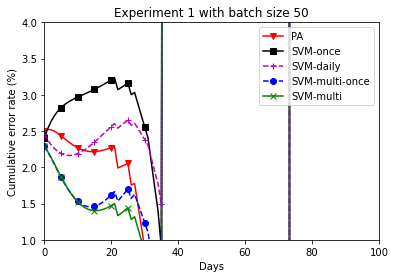

In [57]:
plot8degree(error_rates_pa, error_rates_svm_once, error_rates_svm_daily,
                error_rates_svm_multi_once, error_rates_svm_multi, batch_size, False)

In [ ]:
plot8degree(error_rates_pa, error_rates_svm_once, error_rates_svm_daily,
                error_rates_svm_multi_once, error_rates_svm_multi, batch_size, True)